In [1]:
# Gerekli Kütüphaneler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# Veri Setinin Yüklenmesi
veri_yolu = "/content/drive/MyDrive/Örüntü-Tanıma-Veri-Seti/emotions.csv"
veri_seti = pd.read_csv(veri_yolu)

In [3]:
# Verinin Hazırlanması
def veri_hazirla(veri_seti):
    kodlama = {'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} 
    kodlanmis_veri = veri_seti.replace(kodlama)

    X = kodlanmis_veri.drop(["label"], axis=1)
    y = tf.keras.utils.to_categorical(kodlanmis_veri['label'].values)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y

In [4]:
pozitif_veri = veri_seti[veri_seti["label"]=="POSITIVE"]
negatif_veri = veri_seti[veri_seti["label"]=="NEGATIVE"]
notr_veri = veri_seti[veri_seti["label"]=="NEUTRAL"]

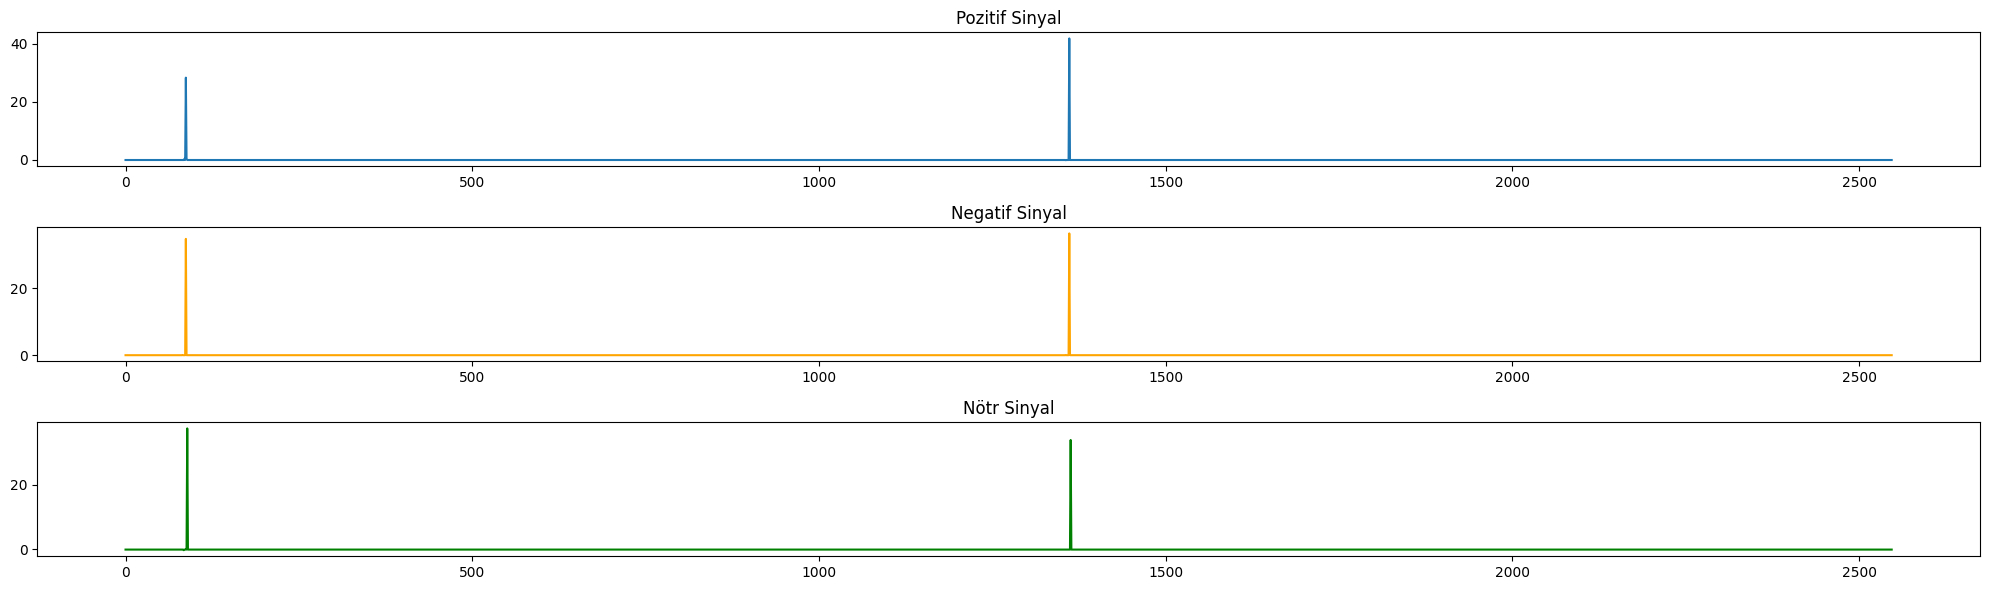

In [5]:
# Pozitif, Negatif ve Nötr örneklere erişim
pozitif_ornek = pozitif_veri.iloc[0,:-1]
negatif_ornek = negatif_veri.iloc[0,:-1]
notr_ornek = notr_veri.iloc[0,:-1]

# Sinyallerin StandardScaler ile ölçeklendirilmesi
scaler = StandardScaler()

pozitif_ornek_scaled = scaler.fit_transform(pozitif_ornek.values.reshape(-1, 1))
negatif_ornek_scaled = scaler.fit_transform(negatif_ornek.values.reshape(-1, 1))
notr_ornek_scaled = scaler.fit_transform(notr_ornek.values.reshape(-1, 1))

# Her bir sinyalin çizilmesi
plt.figure(figsize=(20,6))

plt.subplot(3,1,1)
plt.plot(pozitif_ornek_scaled)
plt.title('Pozitif Sinyal')

plt.subplot(3,1,2)
plt.plot(negatif_ornek_scaled, 'orange')
plt.title('Negatif Sinyal')

plt.subplot(3,1,3)
plt.plot(notr_ornek_scaled, 'green')
plt.title('Nötr Sinyal')

plt.tight_layout()
plt.show()

In [6]:
# Verinin Hazırlanması ve Eğitim/Test Kümelerine Ayırma
X, y = veri_hazirla(veri_seti)
X_egitim, X_test, y_egitim, y_test = train_test_split(X, y, test_size=0.2, random_state=4)


In [21]:
# Modelin Hazırlanması
def model_olustur():
    model = tf.keras.Sequential()   
    model.add(tf.keras.layers.Reshape((X_egitim.shape[1], 1), input_shape=(X_egitim.shape[1],)))   
    # İlk GRU katmanı. 1024 nöron ile katman eklendi.
    model.add(tf.keras.layers.GRU(1024, return_sequences=True))   
    # Dropout katmanı. Overfitting'i önlemek için kullanılır.
    model.add(tf.keras.layers.Dropout(0.2))   
    # İkinci GRU katmanı.
    model.add(tf.keras.layers.GRU(2048, return_sequences=True))   
    # Tekrar Dropout katmanı.
    model.add(tf.keras.layers.Dropout(0.3))
    # Üçüncü GRU katmanı
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Flatten())   
    # Tam bağlantılı katman (Dense layer)
    model.add(tf.keras.layers.Dense(32, activation='relu'))    
    # Son katman. Sınıflandırma işlemi burada gerçekleşir.
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
# Modelin Eğitilmesi
model = model_olustur()
gecmis = model.fit(X_egitim, y_egitim, epochs=15, validation_split=0.1)

Epoch 1/15
48/48 [==============================] - 33s 584ms/step - loss: 0.8530 - accuracy: 0.6323 - val_loss: 1.7413 - val_accuracy: 0.3509
Epoch 2/15
48/48 [==============================] - 27s 568ms/step - loss: 0.9862 - accuracy: 0.5046 - val_loss: 0.8381 - val_accuracy: 0.5731
Epoch 3/15
48/48 [==============================] - 27s 568ms/step - loss: 0.8409 - accuracy: 0.6043 - val_loss: 0.6860 - val_accuracy: 0.6082
Epoch 4/15
48/48 [==============================] - 27s 567ms/step - loss: 0.5763 - accuracy: 0.6969 - val_loss: 0.6195 - val_accuracy: 0.6140
Epoch 5/15
48/48 [==============================] - 27s 567ms/step - loss: 0.5468 - accuracy: 0.6956 - val_loss: 0.6020 - val_accuracy: 0.6257
Epoch 6/15
48/48 [==============================] - 27s 567ms/step - loss: 0.5239 - accuracy: 0.7177 - val_loss: 0.5049 - val_accuracy: 0.7310
Epoch 7/15
48/48 [==============================] - 27s 567ms/step - loss: 0.4247 - accuracy: 0.8357 - val_loss: 0.3503 - val_accuracy: 0.8655

In [23]:
# Modelin Değerlendirilmesi
kayip, dogruluk = model.evaluate(X_test, y_test)
print(f"Test veri setindeki kayıp: {kayip*100}",f"\nEğitim veri setindeki doğruluk: {dogruluk*100}")

14/14 [==============================] - 3s 246ms/step - loss: 0.2006 - accuracy: 0.9391
Test veri setindeki kayıp: 20.055508613586426 
Eğitim veri setindeki doğruluk: 93.91100406646729


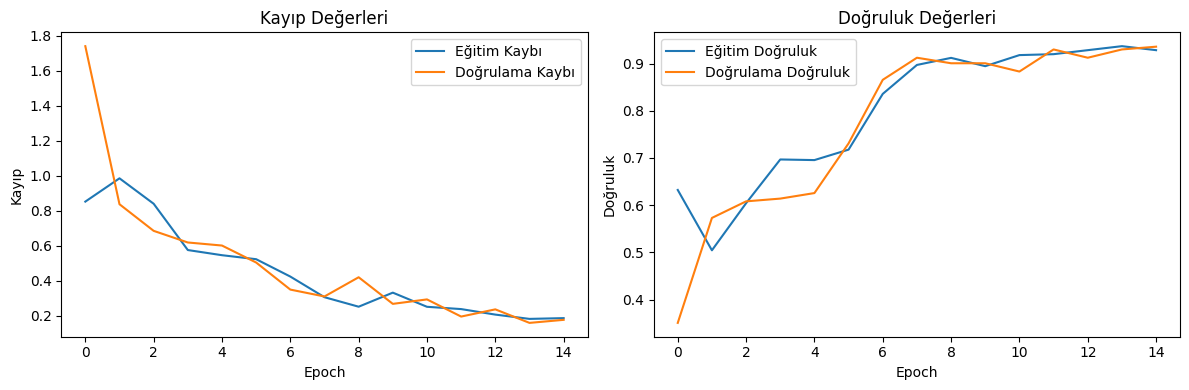

In [24]:
# Kayıp ve Doğruluk Değerlerinin Grafiği
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(gecmis.history['loss'], label='Eğitim Kaybı')
plt.plot(gecmis.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Değerleri')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gecmis.history['accuracy'], label='Eğitim Doğruluk')
plt.plot(gecmis.history['val_accuracy'], label='Doğrulama Doğruluk')
plt.title('Doğruluk Değerleri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
# Modelin Değerlendirilmesi ve Doğruluk Matrisi
kayip, dogruluk = model.evaluate(X_test, y_test)
tahminler = model.predict(X_test)
tahmin_etiketleri = np.argmax(tahminler, axis=1)
gercek_etiketler = np.argmax(y_test, axis=1)

print(classification_report(gercek_etiketler, tahmin_etiketleri))

14/14 [==============================] - 4s 243ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       153
           1       0.95      0.87      0.90       142
           2       0.90      0.98      0.93       132

    accuracy                           0.94       427
   macro avg       0.94      0.94      0.94       427
weighted avg       0.94      0.94      0.94       427

